In [1]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /private/var/folders/jc/1tpd4mn55nd4g3zr2nn7jm7c0000gn/T/pip-req-build-0tks99w4
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /private/var/folders/jc/1tpd4mn55nd4g3zr2nn7jm7c0000gn/T/pip-req-build-0tks99w4
  xcrun: error: invalid active developer path (/Library/Developer/CommandLineTools), missing xcrun at: /Library/Developer/CommandLineTools/usr/bin/xcrun
ERROR: Command errored out with exit status 1: git clone -q https://github.com/qubvel/segmentation_models.pytorch /private/var/folders/jc/1tpd4mn55nd4g3zr2nn7jm7c0000gn/T/pip-req-build-0tks99w4 Check the logs for full command output.
You should consider upgrading via the '/Users/ivanoleinik/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [2]:
import os
import heapq
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data
from tqdm.auto import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from PIL import Image, ImageDraw
from segmentation_models_pytorch import *

In [3]:
EPS = 1e-10
SEED = 1337
SIZE = 64

def fixSeeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
fixSeeds(SEED)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


### Speciify paths to the train data (input and target tensors)

'4' at the end of the name of a variable means that 4-connected maps are considered, '8' means that 8-connected maps are considered.

In [5]:
TRAIN = 'data/train_data/inputs'
TARGET4 = 'data/train_data/target4'
TARGET8 = 'data/train_data/target8'

### Load data

In [6]:
def load(path):
    return torch.stack([torch.load(os.path.join(path, f))
                        for f in tqdm([files for _, _, files in os.walk(path)][0])])

X = load(TRAIN).to(torch.float32)
y4 = load(TARGET4).reshape((-1, 1, SIZE, SIZE)).to(torch.float32)
y8 = load(TARGET8).reshape((-1, 1, SIZE, SIZE)).to(torch.float32)

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

In [7]:
dataset4 = torch.utils.data.TensorDataset(X, y4)
dataset8 = torch.utils.data.TensorDataset(X, y8)

def get_data(dataset):
    """split dataset to train, validation, and test parts
       train (80%), validation (10%), test (10%)
    """
    fixSeeds(SEED)
    train, val, test = [], [], {}
    val_size = len(dataset) // 5
    train_size = len(dataset) - val_size
    train_data, val_data = torch.utils.data.random_split(
        dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42),
    )

    val_data, test_data = torch.utils.data.random_split(
        val_data,
        [val_size // 2, val_size - val_size // 2],
        generator=torch.Generator().manual_seed(42),
    )
    train.append(train_data)
    val.append(val_data)
    test = test_data
    return torch.utils.data.ConcatDataset(train), torch.utils.data.ConcatDataset(val), test

train_data4, val_data4, test_data4 = get_data(dataset4)
train_data8, val_data8, test_data8 = get_data(dataset8)

train_loader4 = torch.utils.data.DataLoader(train_data4, batch_size=128, shuffle=True)
val_loader4 = torch.utils.data.DataLoader(val_data4, batch_size=128)
test_loader4 = torch.utils.data.DataLoader(test_data4, batch_size=1, shuffle=True)

train_loader8 = torch.utils.data.DataLoader(train_data8, batch_size=128, shuffle=True)
val_loader8 = torch.utils.data.DataLoader(val_data8, batch_size=128)
test_loader8 = torch.utils.data.DataLoader(test_data8, batch_size=1, shuffle=True)

### Visualize data

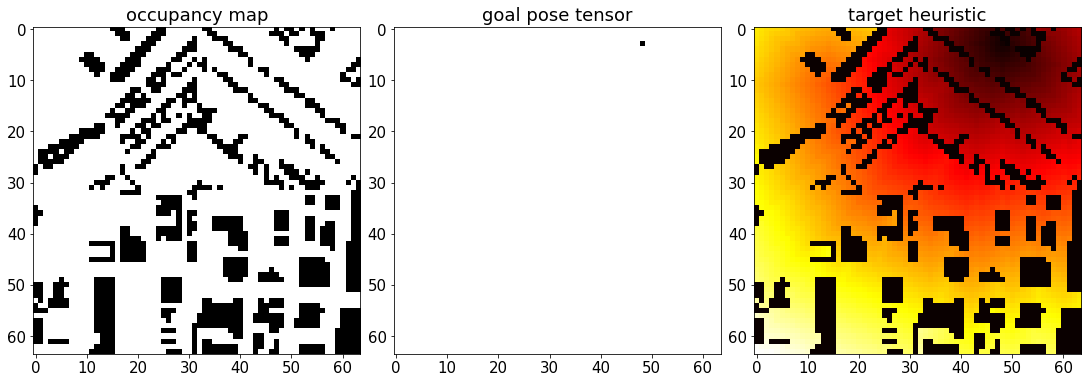

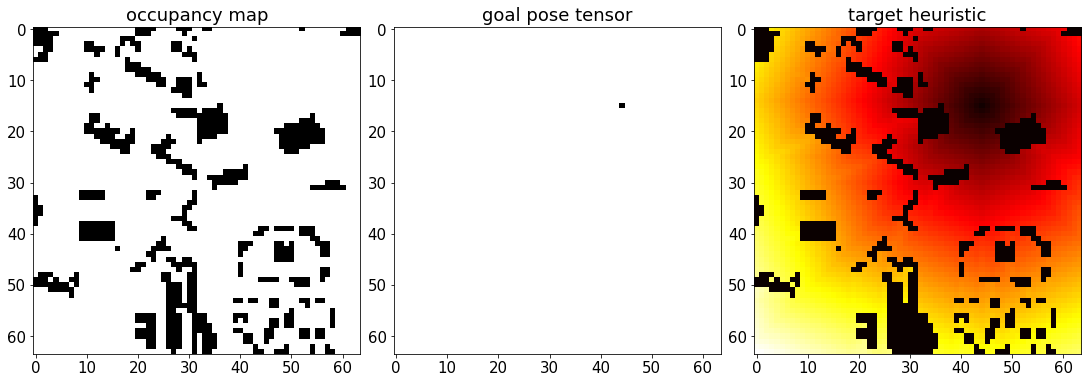

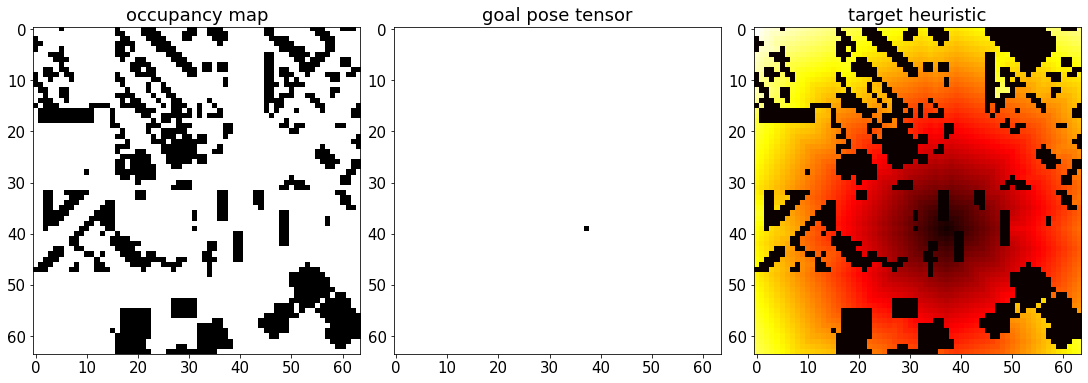

In [8]:
plt.rcParams.update({'font.size': 15})

for i, (X_, y_) in enumerate(train_loader8):
    if i > 2:
        break
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, constrained_layout=True, figsize=(15, 15))
    ax1.set_title('occupancy map')
    ax1.imshow(X_[0, 0], cmap='gist_yarg')
    ax2.set_title('goal pose tensor')
    ax2.imshow(X_[0, 1], cmap='gist_yarg')
    ax3.set_title('target heuristic')
    ax3.imshow(y_[0, 0], cmap='hot')

### Learning process

In [9]:
def tanh2val(x):
    """convert a NN's output to the heuristic values"""
    return (x + 1) * SIZE ** 2 / 2

In [10]:
def show_progress(t, fig_name=None):
    clear_output(wait=True)
    fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(15, 8))
    ax.set_title('loss')
    ax.set_xlabel('time (epochs)')
    ax.set_ylabel('loss')
    ax.plot(train_ts, train_loss, c='darkblue', lw=3)
    ax.plot(val_ts, val_loss, c='green', marker='o', lw=5)
    if fig_name:
        fig.savefig(f'{fig_name}.jpg', bbox_inches='tight')
    plt.show()

In [11]:
def train(epoch, dataloader, model, loss_fn, optimizer):
    model.train()
    num_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        # Send data to training device
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = tanh2val(model(X))
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Progress output
        if loss.item() < 15 and batch % interval == 0:
            t = epoch + (batch + 1)/num_batches
            train_ts.append(t)
            train_loss.append(loss.item())
            show_progress(t)

In [12]:
def test(epoch, dataloader, model, loss_fn, fig_name=None):
    model.eval()
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = tanh2val(model(X))
            test_loss += loss_fn(pred, y).item()
    if test_loss / num_batches < 15:
        test_loss /= num_batches
        val_ts.append(epoch+1)
        val_loss.append(test_loss)
        show_progress(epoch+1, fig_name)

### Model

In [13]:
MODEL_PATH = 'model'

In [14]:
interval = 10
train_ts, train_loss = [], []
val_ts, val_loss = [], []

def MAELoss(output, target):
    mask = target > -.5
    return torch.mean(torch.abs(output[mask] - target[mask]))

class Model:
    def __init__(self, filename, loss_fn, epochs=200):
        self.loss_fn = loss_fn
        self.epochs = epochs
        fixSeeds(SEED)
        self.net = UnetPlusPlus(
            encoder_name='efficientnet-b7',
            encoder_weights=None,
            in_channels=2,
            activation='tanh'
        ).to(device)
        self.metric = 0
        self.filename=filename
        
    def fit(self, train_loader, val_loader, interval=10):
        optimizer = torch.optim.Adam([
            {'params': self.net.decoder.parameters(), 'lr': 1e-2},
            {'params': self.net.encoder.parameters(), 'lr': 1e-3},
        ])
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, self.epochs)
        
        global train_ts, train_loss
        global val_ts, val_loss
        train_ts, train_loss = [], []
        val_ts, val_loss = [], []
        for t in trange(self.epochs):
            train(t, train_loader, self.net, self.loss_fn, optimizer)
            test(t, val_loader, self.net, self.loss_fn, self.loss_fn.__name__ if t == self.epochs - 1 else None)
            scheduler.step()
        torch.save(self.net.state_dict(), os.path.join(MODEL_PATH, filename))
            
    def predict(self, X):
        self.net.eval()
        with torch.no_grad():
            pred = tanh2val(self.net(X))
        return pred

Run these only if you need to train a model

In [16]:
ModelMAE8 = Model('model_8conn.pt', MAELoss)
ModelMAE8.fit(train_loader8, val_loader8)

In [17]:
ModelMAE4 = Model('model_4conn.pt', MAELoss)
ModelMAE4.fit(train_loader4, val_loader4)

### Load a trained model

In [15]:
model_name = 'model_8conn.pt'
ModelMAE8 = Model(model_name, MAELoss)
ModelMAE8.net.load_state_dict(torch.load(os.path.join(MODEL_PATH, model_name), map_location=device))

<All keys matched successfully>

### Visualize predictions

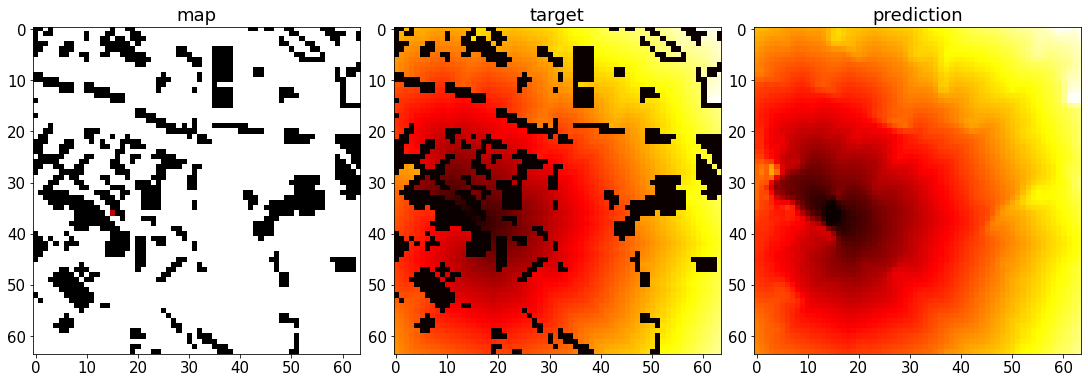

In [76]:
for i, (X_, y_) in enumerate(test_loader8):
    if i > 0:
        break
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, constrained_layout=True, figsize=(15, 10))
    ax0.set_title('map')
    ax0.imshow(-X_[0, 0]-X_[0, 1]/2, cmap='gist_heat')
    ax1.set_title('target')
    ax1.imshow(y_[0, 0], cmap='hot')
    ax2.set_title('prediction')
    ax2.imshow(ModelMAE8.predict(X_.to(device))[0, 0].cpu(), cmap='hot')

### Testing with A*

In [89]:
aY = torch.broadcast_to(torch.arange(0, SIZE), (SIZE, SIZE))
aX = torch.transpose(aY, 0, 1)

def getGoalX(t):
    """return the coordinates of the goal pose by an input tensor"""
    return (t == 1).nonzero()

def getGoal(t):
    """return the coordinates of the goal pose by a target tensor"""
    return (t == 0).nonzero()[0, 1:]

def manhattanH(goalX, goalY, scale=1.0):
    """manhattan distance"""
    return scale * (torch.abs(aX - goalX) + torch.abs(aY - goalY))

def diagonalH(goalX, goalY, scale=1.0):
    """diagonal distance"""
    dx, dy = torch.abs(aX - goalX), torch.abs(aY - goalY)
    return scale * (dx + dy + (np.sqrt(2) - 2) * torch.min(dx, dy))

In [80]:
class Map:
    def __init__(self, mp, k):
        self.height, self.width = mp.shape
        self.cells = mp
        self.k = k

    def inBounds(self, i, j):
        return (0 <= j < self.width) and (0 <= i < self.height)
    
    def Traversable(self, i, j):
        return not self.cells[i][j]

    def GetNeighbors(self, i, j):
        neighbors = []
        if self.k == 4:
            delta = [[0, 1], [1, 0], [0, -1], [-1, 0]]
        elif self.k == 8:
            delta = [[0, 1], [1, 0], [0, -1], [-1, 0], [1, 1], [1, -1], [-1, -1], [-1, 1]]
        
        for d in delta:
            if self.inBounds(i + d[0], j + d[1]) and self.Traversable(i + d[0], j + d[1]):
                neighbors.append((i + d[0], j + d[1]))

        return neighbors

In [81]:
class Node:
    def __init__(self, i, j, g = float('inf'), h = float('inf'), F = None, parent = None):
        self.i = i
        self.j = j
        self.g = g
        if F is None:
            self.F = self.g + h
        else:
            self.F = F        
        self.parent = parent
    
    def __eq__(self, other):
        return (self.i == other.i) and (self.j == other.j)
    
    def __lt__(self, other):
        return ((self.i, self.j) < (other.i, other.j))
    
    def __hash__(self):
        return hash((self.i, self.j))

In [82]:
def Draw(gridMap, start, goal=None, path=None, nodesExpanded=None, nodesOpened=None):
    k = 5
    hIm = gridMap.height * k
    wIm = gridMap.width * k
    im = Image.new('RGB', (wIm, hIm), color = 'white')
    draw = ImageDraw.Draw(im)
    for i in range(gridMap.height):
        for j in range(gridMap.width):
            if(gridMap.cells[i][j] == 1):
                draw.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=( 70, 80, 80 ))

    if nodesOpened is not None:
        for node in nodesOpened:
            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(80, 247, 199), width=0)

    if nodesExpanded is not None:
        for node in nodesExpanded:
            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=( 9, 188, 138 ), width=0)

    if path is not None:
        for step in path:
            if (step is not None):
                if (gridMap.Traversable(step.i, step.j)):
                    draw.rectangle((step.j * k, step.i * k, (step.j + 1) * k - 1, (step.i + 1) * k - 1), fill=(53, 144, 243), width=0)
                else:
                    draw.rectangle((step.j * k, step.i * k, (step.j + 1) * k - 1, (step.i + 1) * k - 1), fill=(230, 126, 34), width=0)

    if (start is not None) and (gridMap.Traversable(start.i, start.j)):
        draw.rectangle((start.j * k, start.i * k, (start.j + 1) * k - 1, (start.i + 1) * k - 1), fill=(155, 229, 100), width=0)
    
    if (goal is not None) and (gridMap.Traversable(goal.i, goal.j)):
        draw.rectangle((goal.j * k, goal.i * k, (goal.j + 1) * k - 1, (goal.i + 1) * k - 1), fill=(231, 76, 60), width=0)

    return np.asarray(im)

In [83]:
class OpenList:
    def __init__(self):
        self.elements = []
    
    def __iter__(self):
        return iter(self.elements)

    def __len__(self):
        return len(self.elements)

    def isEmpty(self):
        if len(self.elements) != 0:
            return False
        return True
    
    def GetBestNode(self):
        bestF = float('inf')
        bestCoord = 0
        for i in range(len(self.elements)):
            if (self.elements[i].F < bestF) or (abs(self.elements[i].F - bestF) < EPS):
                bestCoord = i
                bestF = self.elements[i].F
                
        best = self.elements.pop(bestCoord)
        return best

    def AddNode(self, item : Node):
        for coord in range(len(self.elements)):
            if self.elements[coord].i == item.i and self.elements[coord].j == item.j:
                if (self.elements[coord].g > item.g) or (abs(self.elements[coord].g - item.g) < EPS):
                    self.elements[coord].F = item.F
                    self.elements[coord].g = item.g
                    self.elements[coord].parent = item.parent
                    return
                else:
                    return
        self.elements.append(item)
        return

In [84]:
class ClosedList():
    def __init__(self):
        self.elements = []

    def __iter__(self):
        return iter(self.elements)
    
    def __len__(self):
        return len(self.elements)
    
    def AddNode(self, item : Node, *args):
        self.elements.append(item)

    def WasExpanded(self, item : Node, *args):
        return item in self.elements

In [85]:
def MakePath(goal):
    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

In [86]:
def dist(p, q):
    x1, y1 = p
    x2, y2 = q
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5

In [87]:
def AStar(gridMap, startX, startY, goalX, goalY, heuristic):
    OPEN = OpenList()
    CLOSED = ClosedList()
    OPEN.AddNode(Node(i=startX, j=startY, g=0, h=heuristic[startX][startY]))
    while not OPEN.isEmpty():
        bestNode = OPEN.GetBestNode()
        if CLOSED.WasExpanded(bestNode):
            continue
        CLOSED.AddNode(bestNode)
        if bestNode == Node(i=goalX, j=goalY):
            return (True, bestNode, CLOSED, OPEN)
        for iNeighbor, jNeighbor in gridMap.GetNeighbors(bestNode.i, bestNode.j):
            OPEN.AddNode(Node(i=iNeighbor,
                              j=jNeighbor,
                              g=bestNode.g + dist((bestNode.i, bestNode.j), (iNeighbor, jNeighbor)),
                              h=heuristic[iNeighbor][jNeighbor],
                              parent=bestNode))

    return False, None, CLOSED, OPEN

Difficulty: 2.172532558441162
Difficulty estimation: 2.169398069381714
Expanded nodes ratio: 0.22970903522205208 (Learned), 0.8085758039816233 (Scaled Diagonal 1.5)
Path length ratio: 1.0 (Learned), 1.0193987623470324 (Scaled Diagonal 1.5)


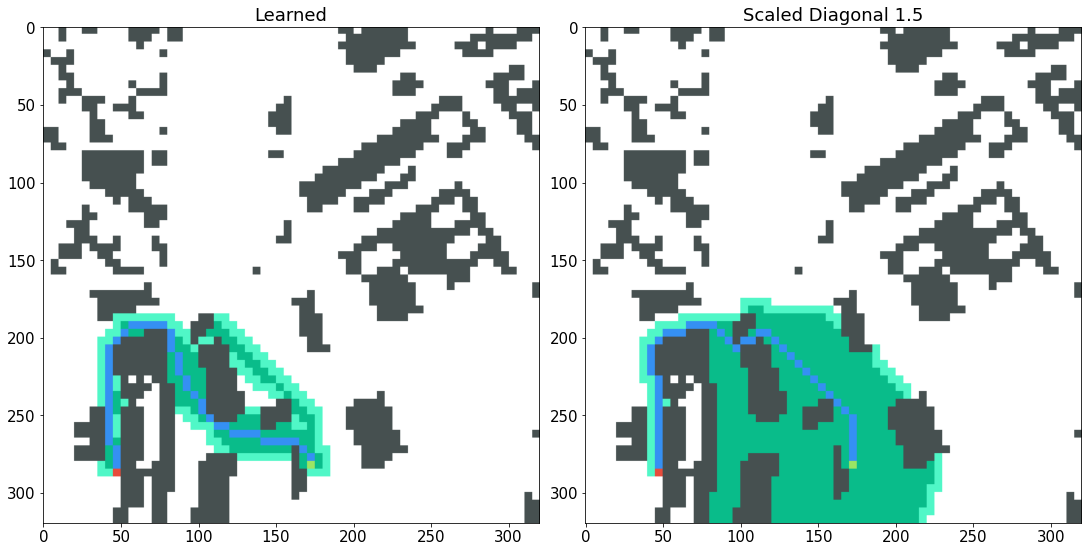

In [96]:
def run_a_test():
    for i, (X, y) in enumerate(test_loader8):
        X, y = X.to(device), y.to(device)
        goalX, goalY = getGoal(y[0])
        baseH = diagonalH(goalX, goalY)
        scaledBaseH = diagonalH(goalX, goalY, 1.5)
        gridMap = Map(X[0, 0], 8)

        for j in range(10):
            startX, startY = np.random.randint(0, 64, 2)
            difficulty = y[0, 0, startX, startY] / baseH[startX][startY]
            if not X[0, 0, startX, startY] and y[0, 0, startX, startY] > -.5 and difficulty > 1.3:
                break
        if j == 9:
            continue
            
        _, goalBaseH, nodesExpandedBaseH, nodesOpenedBaseH = AStar(gridMap, startX, startY, goalX, goalY, baseH)
        pathBaseH, lengthBaseH = MakePath(goalBaseH)

        h = ModelMAE8.predict(X)[0, 0]
        _, goal, nodesExpanded, nodesOpened = AStar(gridMap, startX, startY, goalX, goalY, h)
        path, length = MakePath(goal)
        _, goalScaledBaseH, nodesExpandedScaledBaseH, nodesOpenedScaledBaseH = AStar(gridMap, startX, startY, goalX, goalY, scaledBaseH)
        pathScaledBaseH, lengthScaledBaseH = MakePath(goalScaledBaseH)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(15, 8))
        ax1.set_title('Learned')
        ax1.imshow(Draw(gridMap, Node(startX, startY), goal, path, nodesExpanded, nodesOpened))
        ax2.set_title('Scaled Diagonal 1.5')
        ax2.imshow(Draw(gridMap, Node(startX, startY), goalScaledBaseH, pathScaledBaseH, nodesExpandedScaledBaseH, nodesOpenedScaledBaseH))
        
        print(f'Difficulty: {float(difficulty)}')
        print(f'Difficulty estimation: {h[startX, startY] / baseH[startX][startY]}')
        print(f'Expanded nodes ratio: {len(nodesExpanded) / len(nodesExpandedBaseH)} (Learned), {len(nodesExpandedScaledBaseH) / len(nodesExpandedBaseH)} (Scaled Diagonal 1.5)')
        print(f'Path length ratio: {float(length) / float(lengthBaseH)} (Learned), {float(lengthScaledBaseH) / float(lengthBaseH)} (Scaled Diagonal 1.5)')
        break

run_a_test()